# Dataset Comparison

### Imports

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap



### Load Data

In [4]:
folder_path = os.path.join('..', 'processed_data')
file_names = ['OhioT1DM.csv', 'tidepool_dataset.csv', 'T1DEXI.csv', 'T1DEXIP.csv']

datasets = {}
for dataset_name in file_names:
    df = pd.read_csv(os.path.join(folder_path, dataset_name), index_col='date', parse_dates=['date'], low_memory=False)
    
    all_dfs = []
    # Trim data in beginning and end of each subject test / train 
    for subject_id, subset_df in df.groupby('id'): 
        for is_test in [False, True]:
            subject_split_df = subset_df[subset_df['is_test'] == is_test]
            
            cgm_col = 'CGM_smoothed' if 'CGM_smoothed' in subject_split_df.columns else 'CGM'
            first_valid_index = subject_split_df[cgm_col].first_valid_index()
            last_valid_index = subject_split_df[cgm_col].last_valid_index()
            if first_valid_index is not None and last_valid_index is not None:
                trimmed_subject_data = subject_split_df.loc[first_valid_index:last_valid_index]
                all_dfs.append(trimmed_subject_data)
            else:
                print("No data, skipping subject...")
    df = pd.concat(all_dfs)
    datasets[dataset_name.split('.')[0]] = df

No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipping subject...
No data, skipp

### Print Dataset Key Numbers

In [3]:
def print_numbers_for_datasets(df):
    n = len(df['id'].unique())
    total_samples_in_years = df['CGM'].notna().shape[0] / 12 / 24 / 365 # in years!
    
    if n == 0:
        average_per_subject = 0
    else:
        average_per_subject = total_samples_in_years * 365 / 30 / n
    
    # For the standard deviation, calculate the time span for each subject and then find the std
    time_span_per_subject = df[df['CGM'].notna()].groupby('id').size() / (12 * 24 * 30)
    std_time_span = np.std(time_span_per_subject)

    print(f"n={n}, total samples={total_samples_in_years:.1f} years, average time span={average_per_subject:.1f} months, std={std_time_span:.1f}")


In [4]:
for key in datasets:
    print(key)
    print_numbers_for_datasets(datasets[key])    

OhioT1DM
n=12, total samples=1.8 years, average time span=1.8 months, std=0.1
tidepool_dataset
n=300, total samples=286.5 years, average time span=11.6 months, std=7.6
T1DEXI
n=409, total samples=30.6 years, average time span=0.9 months, std=0.1
T1DEXIP
n=211, total samples=5.9 years, average time span=0.3 months, std=0.1


### Histogram for Number of Samples per Unique Subject ID

In [5]:
def plot_feature_samples_per_subject(df, column, save_fig=False):
    # Group by 'id' and count non-null 'CGM' values
    counts = df.groupby('id')[f'{column}'].count()
    
    # Plot histogram
    plt.figure(figsize=(8, 2))
    plt.hist(counts, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel(f'Number of {column} Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column} samples per ID')
    
    plt.show()
    
    if save_fig:
        plt.savefig(f'{column}_feature_samples_per_subject.png')

In [6]:
df_list = []
for key in datasets:
    df_list.append(datasets[key])

concat_df = pd.concat(df_list)

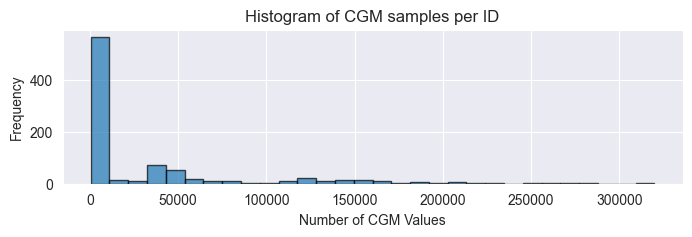

In [7]:
plot_feature_samples_per_subject(concat_df, 'CGM')

### Feature Sparsity

In [13]:
def draw_sparsity_matrix(dataset_dict):
    sparsity_matrix = {}

    for name, df in dataset_dict.items():
        if 'CGM_smoothed' in df.columns:
            df = df.copy()
            df['CGM'] = df['CGM_smoothed']
        
        # Replace 0.0 and empty strings with NaN
        df = df.replace([0.0, ''], np.nan)

        columns = [col for col in df.columns if not 'id' in col and not 'is_test' in col and not 'smoothed' in col and not 'insulin' in col] 
        sparsity = round(df[columns].isna().mean() * 100, 1)  # Calculate percentage of missing values for each feature
        
        new_name = name.replace('_imputed', '')
        new_name = new_name.replace('_', ' ')
        sparsity_matrix[new_name] = sparsity  # Store the sparsity for this dataset
    
    # Convert sparsity_matrix to a DataFrame
    sparsity_df = pd.DataFrame(sparsity_matrix)

    # Sort with features with low sparsity first
    sparsity_df_filled = sparsity_df.fillna(100)    
    sparsity_df = sparsity_df.loc[sparsity_df_filled.mean(axis=1).sort_values(ascending=True).index]
    
    sparsity_df.index = sparsity_df.index.str.replace('_', ' ')
    sparsity_df.rename(columns={'tidepool dataset': 'Tidepool Dataset'}, inplace=True)
    
    cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
    cmap.set_bad('#E0E0E0')  # Set custom color for NaN cells

    # Create annotation matrix where NaN values are replaced by "NaN"
    annotations = sparsity_df.copy()
    annotations = annotations.applymap(lambda x: "NaN" if pd.isna(x) else f"{x:.1f}")

    # Plot heatmap
    plt.figure(figsize=(10, len(sparsity_df) * 0.5))  # Adjust the height dynamically

    # Set NaN cells' color by customizing the color map
    ax = sns.heatmap(sparsity_df, annot=annotations, cmap=cmap, 
                annot_kws={'size': 14},  # Change the font size here (adjust as needed)
                cbar_kws={'label': 'Sparsity (%)'}, 
                linewidths=0.5, 
                cbar=True, linecolor='white', fmt="")  # fmt="" to avoid issues with NoneType
    # Change the font size of the color bar label
    cbar = ax.collections[0].colorbar
    cbar.set_label('Sparsity (%)', fontsize=14)  # Adjust fontsize as needed

    plt.title('Feature Sparsity Across Datasets', fontsize=16)
    plt.ylabel('Feature Name', fontsize=14)
    plt.xlabel('Dataset Name', fontsize=14)
    plt.xticks(fontsize=14)  # Adjust x-axis tick font size and rotation
    plt.yticks(fontsize=14)  # Adjust y-axis tick font size
    
    plt.tight_layout()
    plt.savefig("heatmap.pdf", format='pdf')
    plt.show()


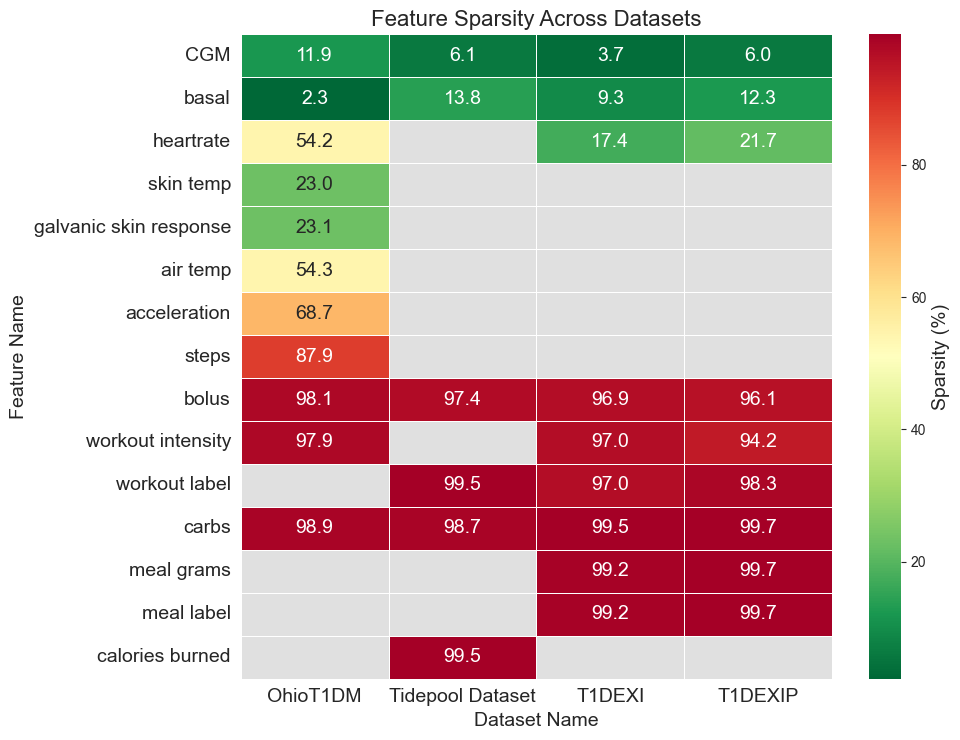

In [14]:
draw_sparsity_matrix(datasets)

In [ ]:
df_ohio = datasets[('OhioT1DM_imputed')]
df_ohio[df_ohio['workout_intensity'].notna()]

## Feature Samples per Dataset

In [15]:
def get_feature_samples_count(dataset_dict):
    feature_samples_matrix = {}
    
    for name, df in dataset_dict.items():
        if 'CGM_smoothed' in df.columns:
            df = df.copy()
            df['CGM'] = df['CGM_smoothed']
            
        
        # Replace 0.0 and empty strings with NaN
        df = df.replace([0.0, ''], np.nan)

        columns = [col for col in df.columns if not 'id' in col and not 'is_test' in col and not 'smoothed' in col and not 'insulin' in col] 

        sparsity_dict = {}

        # Calculate sparsity for each column
        for column in columns:
            sparsity_dict[column] = df[column].notna().sum()  # Count non-null values for each column
        
        # Store the sparsity for this dataset
        new_name = name.replace('_imputed', '')
        new_name = new_name.replace('_', ' ')
        feature_samples_matrix[new_name] = sparsity_dict  # Store sparsity for each column

    samples_count_df = pd.DataFrame(feature_samples_matrix)
    samples_count_df.rename(columns={'tidepool dataset': 'Tidepool Dataset'}, inplace=True)
    samples_count_df.index = samples_count_df.index.str.replace('_', ' ')

    samples_count_df.rename(index={'acceleration': 'acc', 'galvanic skin response': 'gsr'}, inplace=True)

    return samples_count_df

In [16]:
feature_samples_data = get_feature_samples_count(datasets)
feature_samples_data

,OhioT1DM,Tidepool Dataset,T1DEXI,T1DEXIP
CGM,166532.0,28283548.0,3099648.0,583933.0
carbs,2141.0,403575.0,15744.0,1994.0
bolus,3641.0,771074.0,100813.0,24405.0
basal,184587.0,25968064.0,2919668.0,544604.0
gsr,145385.0,NaN,NaN,NaN
skin temp,145530.0,NaN,NaN,NaN
acc,59213.0,NaN,NaN,NaN
workout intensity,3963.0,NaN,97478.0,36264.0
heartrate,86503.0,NaN,2658960.0,486091.0
air temp,86320.0,NaN,NaN,NaN


In [17]:
row_sums = feature_samples_data.sum(axis=1)
feature_samples_data = feature_samples_data.loc[row_sums.sort_values(ascending=False).index]

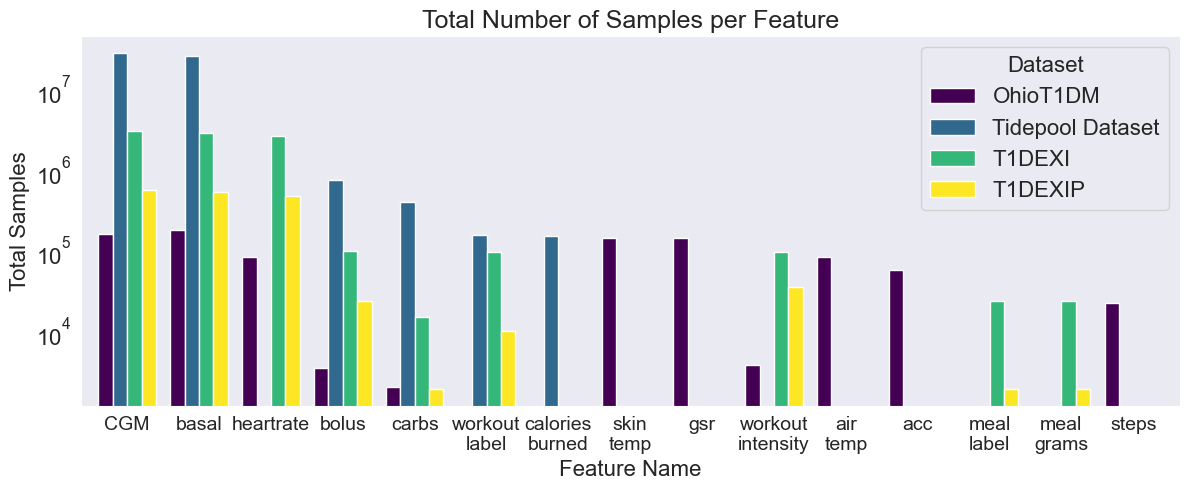

In [18]:
feature_samples_data.plot(kind='bar', stacked=False, figsize=(12,5), colormap="viridis", width=0.8)

plt.xlabel("Feature Name", fontsize=16)
plt.ylabel("Total Samples", fontsize=16)
plt.title("Total Number of Samples per Feature", fontsize=18)
#plt.xticks(rotation=0)#, ha='right')
#plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.legend(title="Dataset", loc='upper right', fontsize=16, title_fontsize=16)
plt.yscale("log")  # Log scale to handle large differences

new_labels_with_newline = [label.replace(' ', '\n') for label in feature_samples_data.index]
plt.xticks(rotation=0, ticks=range(len(feature_samples_data.index)), labels=new_labels_with_newline)

plt.xticks(fontsize=14)
plt.yticks(fontsize=16)

plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.grid(False)
plt.savefig("feature_count.pdf", format='pdf')

plt.show()

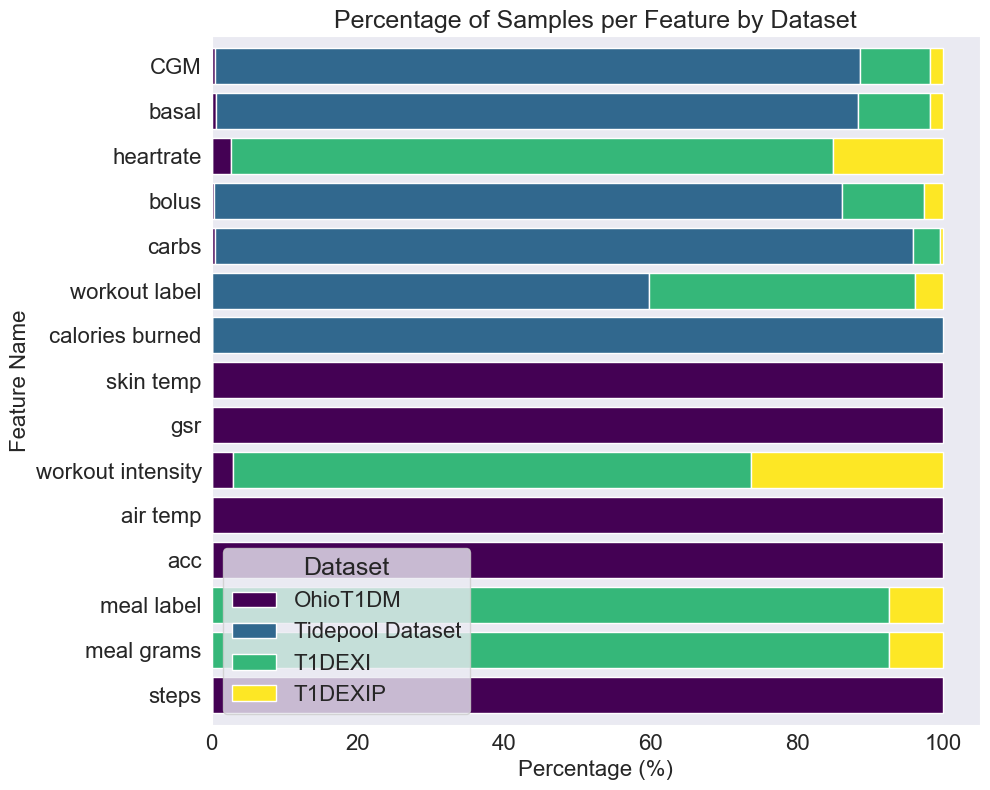

In [26]:
# Normalize the data to calculate percentages
feature_samples_data_percentage = feature_samples_data.div(feature_samples_data.sum(axis=1), axis=0) * 100

# Create a stacked bar plot with the normalized data
#feature_samples_data_percentage.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="viridis", width=0.8)
feature_samples_data_percentage.plot(
    kind='barh',  # 'barh' for horizontal bars
    stacked=True, 
    figsize=(10, 8),  # Adjust the width and height for horizontal orientation
    colormap="viridis", 
    width=0.8
)

# Update labels and title
plt.xlabel("Percentage (%)", fontsize=16)
plt.ylabel("Feature Name", fontsize=16)
plt.title("Percentage of Samples per Feature by Dataset", fontsize=18)

# Update x-axis labels to include newlines for readability
#new_labels_with_newline = [label.replace(' ', '\n') for label in feature_samples_data.index]
#plt.xticks(rotation=0, ticks=range(len(feature_samples_data.index)), labels=new_labels_with_newline, fontsize=14)

# Update y-axis ticks and font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add a legend in the upper-right corner
plt.legend(title="Dataset", loc='lower left', fontsize=16, title_fontsize=18)

# Add gridlines for the y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout to avoid clipping and save the plot
plt.tight_layout()
plt.grid(False)
plt.savefig("feature_percentage_stacked.svg", format='svg')

# Show the plot
plt.show()
